# CZDT ISS Analyses & Access Demo

This notebook demonstrates data subsetting, access & simple analysis for "what now" data in the ISS record.

In [1]:
import requests
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image, display
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont
import pandas as pd
import yaml

In [2]:
import plotting
import processing

In [3]:
from processing import NEXUS_URL

print(f'Configured SDAP-NEXUS endpoint at {NEXUS_URL}. If incorrect, edit processing.py and restart.')

Configured SDAP-NEXUS endpoint at http://sdap.czdt.smce.nasa.gov/nexus. If incorrect, edit processing.py and restart.


First let's list the collections currently in the ISS system.

In [4]:
def get_datasets(cache=True):
    params = {}

    if not cache:
        params['nocached'] = 1
    
    response = requests.get(f'{NEXUS_URL}/list', params=params)
    response.raise_for_status()
    return pd.DataFrame(response.json())[['shortName', 'iso_start', 'iso_end', 'type']]

get_datasets()

,shortName,iso_start,iso_end,type
0,AVHRR_OI_L4_GHRSST_NCEI,2015-11-01T00:00:00+0000,2015-11-30T00:00:00+0000,nexusproto
1,LIS_LSM_FloodedFrac_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
2,LIS_LSM_RiverDepth_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
3,LIS_LSM_RiverFlowVelocity_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
4,LIS_LSM_SWS_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
5,LIS_LSM_Streamflow_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
6,LIS_LSM_SurfElev_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
7,LIS_LSM_gridded_FloodedFrac_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
8,LIS_LSM_gridded_RiverDepth_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
9,LIS_LSM_gridded_RiverFlowVelocity_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto


Now let's register some example Zarr datasets. In normal operation, this would be done automatically as new data granules are ingested into the digital record.

(Note: Some of these may report an error if they already exist, in that case, you may safely proceed)

In [5]:
def add_anon_zarr_collection(name, s3_src_url, variable, latitude='latitude', longitude='longitude', time='time', region='us-west-2'):
    url = f'{NEXUS_URL}/datasets/add'

    params = dict(name=name, path=s3_src_url)
    headers = {"Content-Type": "application/yaml"}

    data = {
        "variable": variable,
        "coords": {
            "latitude": latitude,
            "longitude": longitude,
            "time": time
        },
        "aws": {
            "public": True,
            "region": region
        }
    }

    response = requests.post(url, params=params, headers=headers, data=yaml.dump(data).encode('utf-8'))

    if response.ok:
        print(f'Successfully added collection {name}')
    else:
        print(response.text)

def delete_anon_zarr_collection(name):
    url = f'{NEXUS_URL}/datasets/remove'

    params = dict(name=name)

    response = requests.get(url, params=params)

    if response.ok:
        print(f'Successfully deleted collection {name}')
    else:
        print(response.text)

In [6]:
DEMO_ZARR_COLLECTIONS = [
    ('MERRA2_PRECCON_demo', 's3://czdt-sdap-ard-zarr/sample_cubes/merra2_demo.zarr/', 'PRECCON'),
    ('MERRA2_PRECTOT_demo', 's3://czdt-sdap-ard-zarr/sample_cubes/merra2_demo.zarr/', 'PRECTOT'),
    ('MERRA2_PRECTOTCORR_demo', 's3://czdt-sdap-ard-zarr/sample_cubes/merra2_demo.zarr/', 'PRECTOTCORR'),
    ('MUR25_SST_demo', 's3://czdt-sdap-ard-zarr/sample_cubes/mur25_demo.zarr/', 'analysed_sst'),
]

In [7]:
for collection, url, variable in DEMO_ZARR_COLLECTIONS:
    add_anon_zarr_collection(collection, url, variable, latitude='lat', longitude='lon')

get_datasets(cache=False)

Successfully added collection MERRA2_PRECCON_demo
Successfully added collection MERRA2_PRECTOT_demo
Successfully added collection MERRA2_PRECTOTCORR_demo
Successfully added collection MUR25_SST_demo


,shortName,iso_start,iso_end,type
0,AVHRR_OI_L4_GHRSST_NCEI,2015-11-01T00:00:00+0000,2015-11-30T00:00:00+0000,nexusproto
1,LIS_LSM_FloodedFrac_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
2,LIS_LSM_RiverDepth_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
3,LIS_LSM_RiverFlowVelocity_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
4,LIS_LSM_SWS_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
5,LIS_LSM_Streamflow_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
6,LIS_LSM_SurfElev_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
7,LIS_LSM_gridded_FloodedFrac_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
8,LIS_LSM_gridded_RiverDepth_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
9,LIS_LSM_gridded_RiverFlowVelocity_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto


## Demo Case 1: MERRA2 over the Chesapeake Bay AOI

Let's use MERRA2 over the Chesapeake Bay AOI to demonstrate data subsetting and raw data retrieval.

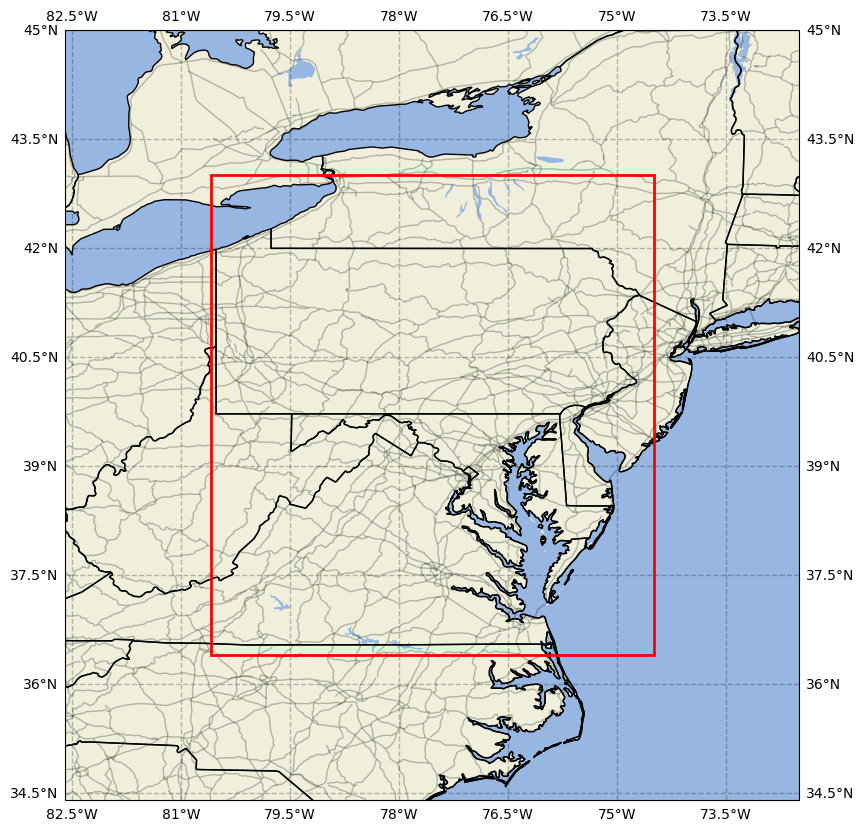

In [8]:
ches_bay_bb = dict(min_lon=-80.595, min_lat=36.405, max_lon=-74.495, max_lat=43.005)
merra2_start = datetime(2025,1,1)
merra2_end = datetime(2025,2,1)

plotting.map_box(ches_bay_bb, padding=2)

In [9]:
subset_PRECTOT = processing.data_subsetting('MERRA2_PRECTOT_demo', ches_bay_bb, merra2_start, merra2_start + timedelta(minutes=30), )
subset_PRECTOT.name = 'PRECTOT'

subset_PRECTOTCORR = processing.data_subsetting('MERRA2_PRECTOTCORR_demo', ches_bay_bb, merra2_start, merra2_start + timedelta(minutes=30), )
subset_PRECTOTCORR.name = 'PRECTOTCORR'

subset_PRECCON = processing.data_subsetting('MERRA2_PRECCON_demo', ches_bay_bb, merra2_start, merra2_start + timedelta(minutes=30), )
subset_PRECCON.name = 'PRECCON'

display(subset_PRECTOT)
display(subset_PRECTOTCORR)
display(subset_PRECCON)

http://sdap.czdt.smce.nasa.gov/nexus/datainbounds?ds=MERRA2_PRECTOT_demo&b=-80.595%2C36.405%2C-74.495%2C43.005&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-01T00%3A30%3A00Z

took 0.33409083299989106 secondsarm...
http://sdap.czdt.smce.nasa.gov/nexus/datainbounds?ds=MERRA2_PRECTOTCORR_demo&b=-80.595%2C36.405%2C-74.495%2C43.005&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-01T00%3A30%3A00Z

took 0.2290701250001348 secondslarm...
http://sdap.czdt.smce.nasa.gov/nexus/datainbounds?ds=MERRA2_PRECCON_demo&b=-80.595%2C36.405%2C-74.495%2C43.005&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-01T00%3A30%3A00Z

took 0.25015174999998635 secondsarm...


<xarray.DataArray 'PRECTOT' (time: 1, lat: 14, lon: 9)> Size: 1kB
array([[[1.08964741e-05, 4.71919775e-05, 6.13927841e-05, 5.24818897e-05,
         5.63682988e-07, 2.20752554e-08, 3.07336450e-07, 5.85801899e-07,
         5.57303429e-06],
        [2.22586095e-06, 2.33575702e-05, 5.80251217e-05, 5.53578138e-05,
         1.98259950e-05, 7.52508640e-07, 2.57790089e-06, 6.14114106e-06,
         8.18446279e-06],
        [1.89319253e-05, 1.42343342e-05, 2.73808837e-05, 7.86408782e-06,
         3.30656767e-05, 1.02855265e-05, 1.04270875e-05, 1.52140856e-05,
         2.44826078e-05],
        [4.61935997e-05, 2.11745501e-05, 7.44499266e-06, 3.29315662e-05,
         4.06801701e-05, 2.32085586e-05, 1.14403665e-05, 1.57356262e-05,
         3.95327806e-05],
        [6.83367252e-05, 3.67164612e-05, 5.57117164e-06, 2.17556953e-05,
         4.77135181e-05, 2.89827585e-05, 6.79492950e-06, 2.46614218e-05,
         4.93675470e-05],
        [4.95910645e-05, 4.34517860e-05, 9.08672810e-05, 2.43246555e-04,
         5.34355640e-05, 4.25875187e-05, 1.41784549e-05, 1.93044543e-05,
         4.23341990e-05],
        [5.46872616e-05, 1.78754330e-04, 9.74416733e-04, 9.10997391e-04,
         1.32799149e-04, 2.57119536e-05, 2.86921859e-05, 1.52029097e-05,
...
         1.65343285e-04, 6.56843185e-05, 3.12179327e-05, 1.75014138e-05,
         4.80860472e-05],
        [2.16186047e-04, 7.03096390e-04, 6.48736954e-04, 1.60753727e-04,
         7.93039799e-05, 1.29818916e-04, 9.30726528e-05, 2.99289823e-05,
         3.67462635e-05],
        [2.28643417e-04, 3.15546989e-04, 8.72910023e-05, 6.24544919e-06,
         9.08672810e-05, 2.24590302e-04, 1.48415565e-04, 3.01823020e-05,
         1.08294189e-05],
        [1.86979771e-04, 1.32024288e-04, 1.84848905e-05, 7.31647015e-06,
         9.06288624e-05, 2.71797180e-04, 1.51515007e-04, 1.15595758e-05,
         7.40168616e-07],
        [6.47902489e-05, 3.36170197e-05, 4.58024442e-06, 1.52029097e-05,
         5.31971455e-05, 1.12205744e-04, 1.81674957e-04, 2.80141830e-05,
         2.89583113e-09],
        [5.46276569e-05, 1.90585852e-05, 2.17482448e-05, 3.64035368e-05,
         6.58035278e-05, 3.68714333e-04, 3.94463539e-04, 1.06304884e-04,
         1.20047480e-06],
        [1.56521797e-04, 1.07914209e-04, 1.42514706e-04, 1.61290169e-04,
         3.40580940e-04, 5.25712967e-04, 2.69651413e-04, 2.44528055e-05,
         6.75208867e-07]]])
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-01-01T00:30:00
  * lat      (lat) float64 112B 36.5 37.0 37.5 38.0 38.5 ... 41.5 42.0 42.5 43.0
  * lon      (lon) float64 72B -80.0 -79.38 -78.75 ... -76.25 -75.62 -75.0

<xarray.DataArray 'PRECTOTCORR' (time: 1, lat: 14, lon: 9)> Size: 1kB
array([[[2.03549862e-05, 1.24692917e-04, 3.36050987e-04, 3.48925591e-04,
         2.18868256e-04, 7.50422478e-05, 1.74855813e-06, 3.37045640e-06,
         1.78301707e-06],
        [1.35973096e-05, 7.63535500e-05, 2.26616859e-04, 3.11017036e-04,
         1.97708607e-04, 7.00950623e-05, 8.81776214e-06, 1.64508820e-05,
         1.69873238e-05],
        [1.94087625e-05, 7.78734684e-05, 1.82092190e-04, 2.58445740e-04,
         2.17676163e-04, 9.07182693e-05, 4.22149897e-05, 2.48923898e-05,
         2.82973051e-05],
        [2.28881836e-05, 5.18113375e-05, 1.37507915e-04, 2.68459320e-04,
         2.48193741e-04, 2.42769718e-04, 1.46329403e-04, 5.31226397e-05,
         7.85887241e-05],
        [2.09659338e-05, 2.91019678e-05, 9.54270363e-05, 4.77433205e-04,
         5.26666641e-04, 5.12838364e-04, 3.93629074e-04, 1.94668770e-04,
         1.05053186e-04],
        [1.73673034e-05, 3.39299440e-05, 6.64949417e-04, 6.26325607e-04,
         7.73668289e-04, 5.69343567e-04, 3.48806381e-04, 2.87055969e-04,
         3.96251678e-04],
        [2.16513872e-05, 1.29938126e-04, 5.50031662e-04, 6.39677048e-04,
         4.12464142e-04, 2.53558159e-04, 2.78711319e-04, 2.39610672e-04,
...
         1.37090683e-04, 1.62243843e-04, 2.80022621e-04, 3.58581543e-04,
         3.50952148e-04],
        [1.06990337e-04, 1.81138515e-04, 2.11358070e-04, 9.53674316e-05,
         6.27040863e-05, 1.23500824e-04, 2.41994858e-04, 3.69429588e-04,
         3.39388847e-04],
        [1.05172396e-04, 8.65757465e-05, 4.36902046e-05, 3.55690718e-05,
         2.77981162e-05, 1.13487244e-04, 1.49130821e-04, 1.65581703e-04,
         1.75833702e-04],
        [5.67436218e-05, 3.54200602e-05, 7.40960240e-06, 2.09212303e-05,
         2.98470259e-05, 1.24275684e-04, 1.58011913e-04, 7.34925270e-05,
         5.73694706e-05],
        [2.70903111e-05, 1.62720680e-05, 6.67944551e-06, 1.25952065e-05,
         2.72765756e-05, 1.36017799e-04, 2.65717506e-04, 1.25885010e-04,
         1.25825405e-04],
        [3.23653221e-05, 2.67177820e-05, 2.50563025e-05, 3.02568078e-05,
         2.89306045e-05, 1.62363052e-04, 3.82661819e-04, 2.16722488e-04,
         3.16053629e-05],
        [4.49120998e-05, 5.25712967e-05, 6.71446323e-05, 7.99596310e-05,
         2.68697739e-04, 2.26318836e-04, 2.87890434e-04, 5.47468662e-05,
         1.50986016e-05]]])
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-01-01T00:30:00
  * lat      (lat) float64 112B 36.5 37.0 37.5 38.0 38.5 ... 41.5 42.0 42.5 43.0
  * lon      (lon) float64 72B -80.0 -79.38 -78.75 ... -76.25 -75.62 -75.0

<xarray.DataArray 'PRECCON' (time: 1, lat: 14, lon: 9)> Size: 1kB
array([[[1.07102096e-05, 4.65214252e-05, 6.05434179e-05, 5.21391630e-05,
         5.48548996e-07, 1.85900717e-08, 3.06754373e-07, 5.85569069e-07,
         5.37373126e-06],
        [1.64238736e-06, 2.22474337e-05, 5.63412905e-05, 5.47766685e-05,
         1.97738409e-05, 7.41798431e-07, 2.57603824e-06, 6.13927841e-06,
         8.12485814e-06],
        [1.36019662e-06, 8.83638859e-06, 2.52872705e-05, 7.67782331e-06,
         3.29613686e-05, 1.02631748e-05, 1.04233623e-05, 1.51656568e-05,
         2.40430236e-05],
        [1.48825347e-06, 6.71111047e-06, 4.86336648e-06, 3.24249268e-05,
         4.03523445e-05, 2.16737390e-05, 9.15303826e-06, 1.39512122e-05,
         3.76701355e-05],
        [1.12177804e-06, 2.41305679e-06, 3.62098217e-06, 1.99824572e-05,
         4.65959311e-05, 2.48849392e-05, 0.00000000e+00, 1.90660357e-05,
         4.69684601e-05],
        [4.24566679e-07, 2.58558430e-07, 1.69053674e-05, 2.67326832e-05,
         4.54783440e-05, 3.53008509e-05, 3.22330743e-06, 1.22413039e-05,
         3.93241644e-05],
        [5.43892384e-07, 4.18745913e-07, 1.02594495e-05, 6.58035278e-05,
         5.50299883e-05, 4.13507223e-06, 1.61454082e-05, 1.77463517e-06,
...
         2.07722187e-05, 3.06367874e-05, 1.05053186e-05, 1.45751983e-06,
         1.88276172e-05],
        [4.06950712e-05, 6.16908073e-06, 3.03611159e-06, 4.35709953e-05,
         2.14725733e-05, 5.68851829e-06, 8.63801688e-07, 0.00000000e+00,
         1.61409844e-07],
        [3.53902578e-07, 0.00000000e+00, 6.44649845e-08, 2.46654963e-08,
         4.60632145e-06, 9.51331458e-09, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-01-01T00:30:00
  * lat      (lat) float64 112B 36.5 37.0 37.5 38.0 38.5 ... 41.5 42.0 42.5 43.0
  * lon      (lon) float64 72B -80.0 -79.38 -78.75 ... -76.25 -75.62 -75.0

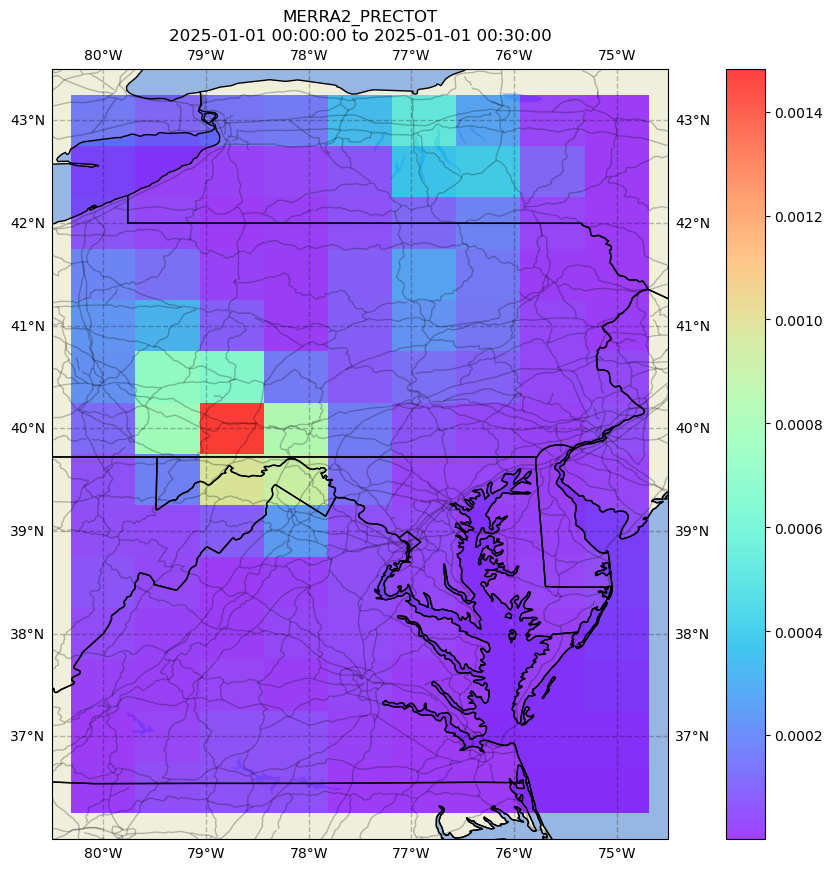

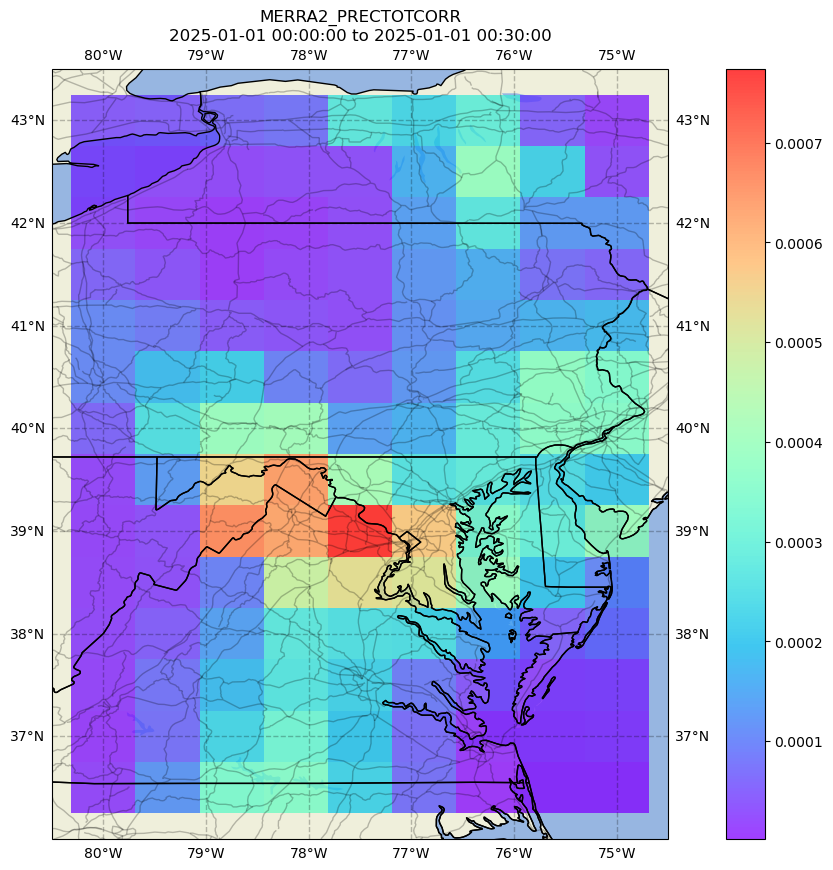

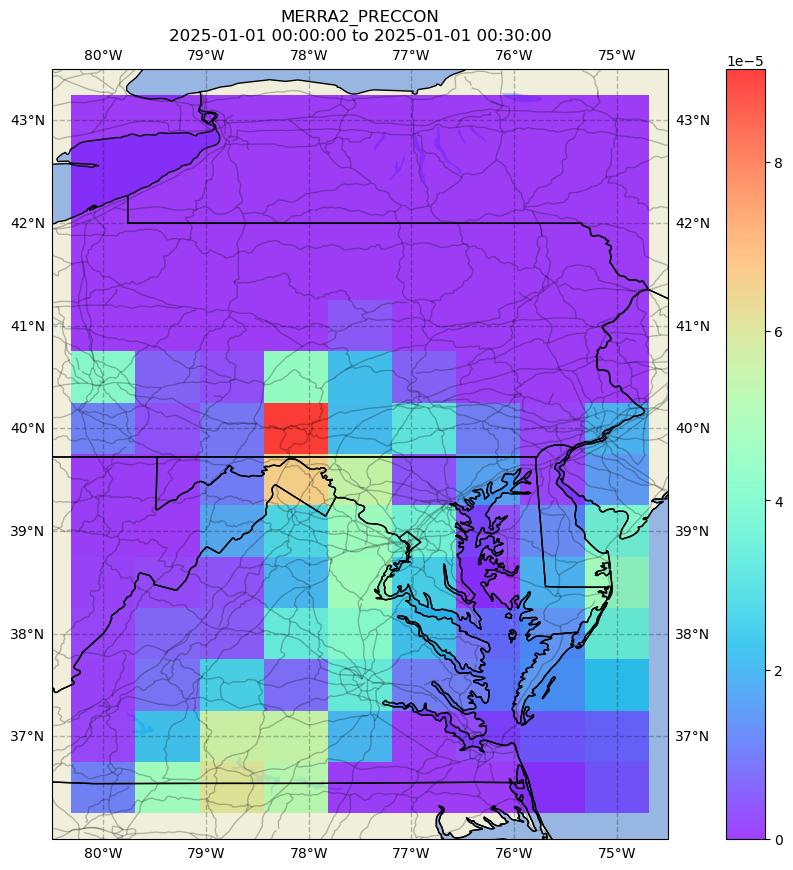

In [10]:
plotting.map_data(subset_PRECTOT[0], f'MERRA2_PRECTOT\n{merra2_start} to {merra2_start + timedelta(minutes=30)}', padding=.5, )
plotting.map_data(subset_PRECTOTCORR[0], f'MERRA2_PRECTOTCORR\n{merra2_start} to {merra2_start + timedelta(minutes=30)}', padding=.5, )
plotting.map_data(subset_PRECCON[0], f'MERRA2_PRECCON\n{merra2_start} to {merra2_start + timedelta(minutes=30)}', padding=.5, )

## Demo Case 2: SST about the El Niño-Southern Oscillation (ENSO) in 2025

Additionally, we can perform analyses like time series over a given AOI and time range.

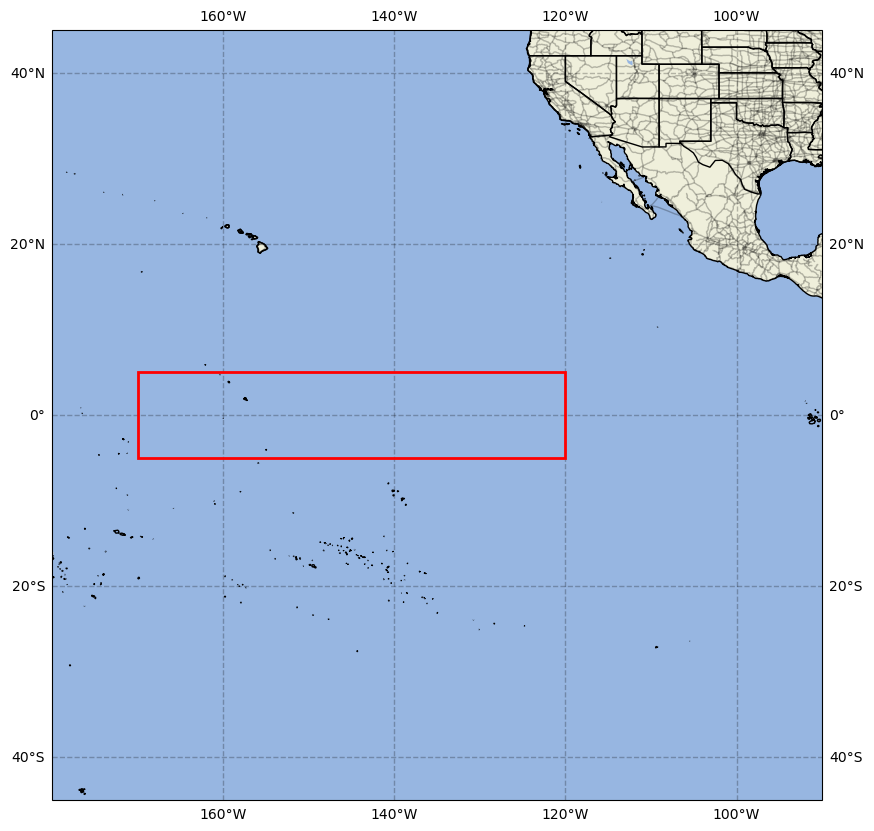

In [11]:
enso_bb = dict(min_lon=-170, min_lat=-5, max_lon=-120, max_lat=5)
mur_start = datetime(2024,1,1, 9)
mur_end = datetime(2025,1,1, 9)

plotting.map_box(enso_bb, padding=(30, 40))

In [12]:
subset = processing.data_subsetting('MUR25_SST_demo', enso_bb, mur_start, mur_start + timedelta(days=0), )
subset.name = 'MUR25_SST'

display(subset)

http://sdap.czdt.smce.nasa.gov/nexus/datainbounds?ds=MUR25_SST_demo&b=-170%2C-5%2C-120%2C5&startTime=2024-01-01T09%3A00%3A00Z&endTime=2024-01-01T09%3A00%3A00Z

took 0.629157707999866 secondsAlarm...


<xarray.DataArray 'MUR25_SST' (time: 1, lat: 40, lon: 200)> Size: 64kB
array([[[303.033, 303.069, 302.911, ..., 299.912, 299.976, 299.981],
        [303.072, 303.071, 303.448, ..., 299.979, 299.98 , 299.909],
        [302.96 , 302.928, 303.375, ..., 299.961, 299.937, 299.953],
        ...,
        [303.459, 303.416, 303.284, ..., 301.251, 300.929, 300.692],
        [303.263, 303.312, 303.445, ..., 301.362, 301.201, 301.042],
        [302.912, 302.837, 302.899, ..., 301.356, 301.04 , 300.792]]],
      shape=(1, 40, 200))
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-01-01T09:00:00
  * lat      (lat) float64 320B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float64 2kB -169.9 -169.6 -169.4 ... -120.6 -120.4 -120.1

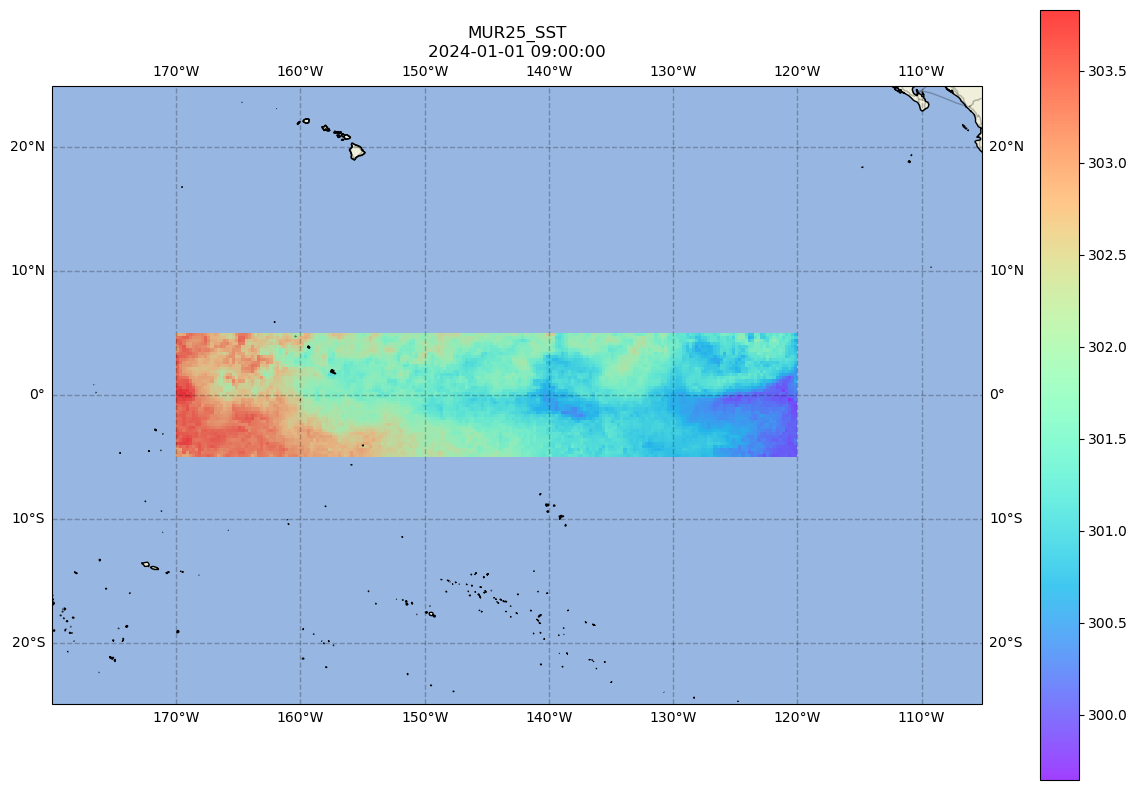

In [13]:
plotting.map_data(subset[0], f'MUR25_SST\n{mur_start}', padding=(15, 20), )

In [14]:
timeseries = processing.spatial_timeseries('MUR25_SST_demo', enso_bb, mur_start, mur_end)
timeseries

http://sdap.czdt.smce.nasa.gov/nexus/timeSeriesSpark?ds=MUR25_SST_demo&minLon=-170&minLat=-5&maxLon=-120&maxLat=5&startTime=2024-01-01T09%3A00%3A00Z&endTime=2025-01-01T09%3A00%3A00Z&lowPassFilter=False

took 15.410069166000085 secondslarm...


<xarray.Dataset> Size: 12kB
Dimensions:  (time: 367)
Coordinates:
  * time     (time) datetime64[s] 3kB 2024-01-01T09:00:00 ... 2025-01-01T09:0...
Data variables:
    mean     (time) float64 3kB 301.7 301.7 301.7 301.6 ... 298.9 299.0 299.0
    minimum  (time) float64 3kB 299.6 299.9 299.8 299.6 ... 295.3 295.7 295.9
    maximum  (time) float64 3kB 303.8 303.8 303.8 303.8 ... 302.1 302.0 302.0

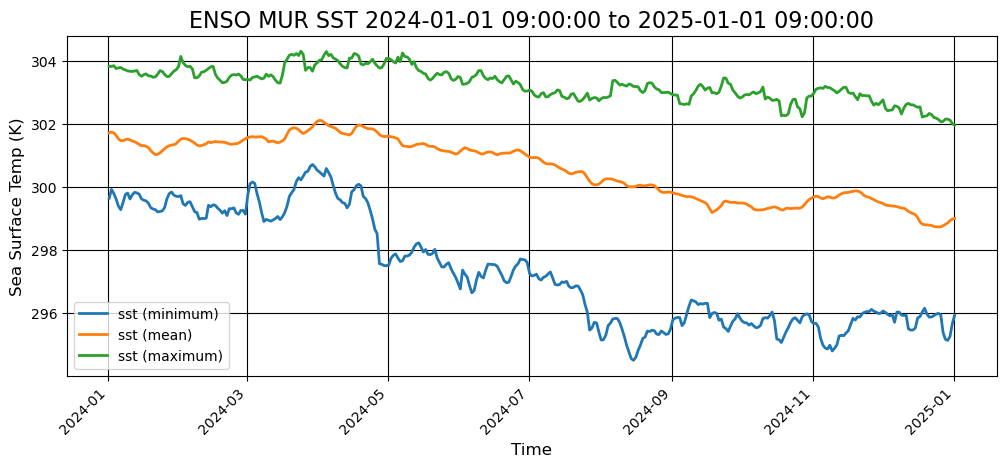

In [15]:
plotting.timeseries_plot(
    [
        (timeseries['minimum'], 'sst (minimum)'),
        (timeseries['mean'], 'sst (mean)'),
        (timeseries['maximum'], 'sst (maximum)')
    ],
    'Time', 
    'Sea Surface Temp (K)', 
    f'ENSO MUR SST {mur_start} to {mur_end}', 
    norm=False
)

## Cleanup

Finally, let's remove the zarr collections we added for this demonstration. Again, management of these collections will nominally be handled automatically by the ISS.

In [16]:
for collection, _, _ in DEMO_ZARR_COLLECTIONS:
    delete_anon_zarr_collection(collection)

get_datasets(cache=False)

Successfully deleted collection MERRA2_PRECCON_demo
Successfully deleted collection MERRA2_PRECTOT_demo
Successfully deleted collection MERRA2_PRECTOTCORR_demo
Successfully deleted collection MUR25_SST_demo


,shortName,iso_start,iso_end,type
0,AVHRR_OI_L4_GHRSST_NCEI,2015-11-01T00:00:00+0000,2015-11-30T00:00:00+0000,nexusproto
1,LIS_LSM_FloodedFrac_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
2,LIS_LSM_RiverDepth_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
3,LIS_LSM_RiverFlowVelocity_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
4,LIS_LSM_SWS_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
5,LIS_LSM_Streamflow_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
6,LIS_LSM_SurfElev_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
7,LIS_LSM_gridded_FloodedFrac_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
8,LIS_LSM_gridded_RiverDepth_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
9,LIS_LSM_gridded_RiverFlowVelocity_tavg,2020-01-01T00:00:00+0000,2020-01-31T00:00:00+0000,nexusproto
